# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_042  Q7Z5L7;Q7Z5L7-2;Q7Z5L7-3   14.312
Sample_170  P01036;P01037              15.249
Sample_058  Q86UD1                     18.001
Sample_184  Q12841;Q12841-2            16.928
Sample_011  P58401                     16.068
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                     
Sample_115  D6RF35                                19.877
Sample_191  P00491                                17.989
Sample_056  A0A0A0MTC8;Q9NQ36;Q9NQ36-2;Q9NQ36-3   14.302
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.661
            A0A075B6Q5                 13.219
            A0A075B6R2                 11.273
            A0A075B6S5                 13.555
            A0A087WSY4                 12.650
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.018
            Q9UI40;Q9UI40-2            13.905
            Q9UIW2                     11.015
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.461
            Q9UP79                     12.349
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.985,15.050,16.842,19.863,16.140,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,17.008,19.067,...,15.528,15.576,13.959,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.942,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.216,17.705,17.039,15.872,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.923,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.142,15.345,17.084,18.708,14.249,19.433,12.075,11.117
Sample_207,15.739,16.877,15.469,16.898,14.879,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.751,11.728,12.010,12.208,12.278,13.280,12.838,12.673,12.540,12.665
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.324,19.067,16.127,...,12.502,12.661,12.166,12.632,12.531,11.245,13.361,14.418,13.194,12.152
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.471,13.396,13.508,12.242,14.009,12.905,12.675,12.923,11.606,13.987
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.144,12.948,13.606,14.180,12.985,13.069,13.061,14.276,12.983,12.763
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.746,12.713,11.947,13.648,13.451,12.106,13.722,12.800,11.777,12.956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.158,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 310.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.21it/s]

100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.10it/s]

100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.06it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.11it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.05it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.31it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.90it/s]

100%|██████████| 5/5 [00:01<00:00,  3.96it/s]

100%|██████████| 5/5 [00:01<00:00,  4.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.24it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.68it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.96it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

100%|██████████| 6/6 [00:01<00:00,  4.01it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.65it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.82it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.12it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.78it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.76it/s]

100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.14it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.02it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.57it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.50it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.38it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.41it/s]

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

100%|██████████| 8/8 [00:02<00:00,  3.44it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.05it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.58it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.74it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.36it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.07it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.85it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.98it/s]

100%|██████████| 9/9 [00:02<00:00,  4.06it/s]

100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.49it/s]

 30%|███       | 3/10 [00:00<00:01,  6.32it/s]

 40%|████      | 4/10 [00:00<00:00,  6.02it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.84it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.42it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.44it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.52it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.58it/s]

100%|██████████| 10/10 [00:01<00:00,  4.59it/s]

100%|██████████| 10/10 [00:01<00:00,  5.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.38it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.04it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.09it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.07it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.66it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.94it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.86it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.85it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.88it/s]

100%|██████████| 11/11 [00:02<00:00,  3.72it/s]

100%|██████████| 11/11 [00:02<00:00,  4.26it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.79it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.39it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.64it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.28it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.28it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.03it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.28it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.41it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.29it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.19it/s]

100%|██████████| 12/12 [00:02<00:00,  4.52it/s]

100%|██████████| 12/12 [00:02<00:00,  4.56it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.76it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.65it/s]

 31%|███       | 4/13 [00:00<00:02,  4.40it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.27it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.32it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.94it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.95it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.02it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.92it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.97it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.96it/s]

100%|██████████| 13/13 [00:03<00:00,  4.05it/s]

100%|██████████| 13/13 [00:03<00:00,  4.19it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.07it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.21it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.43it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.29it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.19it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.11it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.13it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.11it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.23it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.32it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.21it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.23it/s]

100%|██████████| 14/14 [00:03<00:00,  4.22it/s]

100%|██████████| 14/14 [00:03<00:00,  4.35it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.63it/s]

 20%|██        | 3/15 [00:00<00:02,  5.29it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.44it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.54it/s]

 40%|████      | 6/15 [00:01<00:02,  4.41it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.06it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.17it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.26it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.33it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.16it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.34it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.22it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.13it/s]

100%|██████████| 15/15 [00:03<00:00,  4.13it/s]

100%|██████████| 15/15 [00:03<00:00,  4.36it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.053 0.023          0.703 0.394       0.104   
2             0.005 0.004      0.049 0.022          0.712 0.089       0.601   
3             0.004 0.002      0.043 0.014          0.707 0.093       0.618   
4             0.006 0.004      0.050 0.018          0.712 0.077       0.679   
5             0.005 0.004      0.050 0.018          0.724 0.079       0.690   
6             0.004 0.003      0.044 0.017          0.749 0.089       0.687   
7             0.007 0.007      0.075 0.040          0.808 0.084       0.820   
8             0.007 0.005      0.074 0.036          0.801 0.086       0.800   
9             0.004 0.006      0.035 0.004          0.796 0.088       0.791   
10            0.004 0.000      0.037 0.008          0.796 0.087       0.794   
11            0.004 0.002      0.034 0.012          0.802 0.090       0.803   
12            0.004 0.003      0.035 0.010          0.827 0.084       0.828   
13            0.004 0.002      0.040 0.009          0.829 0.079       0.827   
14            0.004 0.001      0.038 0.006          0.829 0.076       0.825   
15            0.005 0.005      0.039 0.008          0.824 0.083       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.174 0.134                  0.545 0.042        0.854   
2          0.102   0.646 0.079                  0.710 0.058        0.784   
3          0.110   0.653 0.084                  0.713 0.063        0.783   
4          0.111   0.690 0.074                  0.738 0.056        0.787   
5          0.113   0.700 0.076                  0.747 0.057        0.785   
6          0.113   0.711 0.083                  0.758 0.063        0.811   
7          0.103   0.809 0.071                  0.837 0.061        0.900   
8          0.111   0.795 0.075                  0.826 0.063        0.902   
9          0.115   0.788 0.079                  0.820 0.066        0.899   
10         0.110   0.790 0.075                  0.821 0.063        0.908   
11         0.108   0.798 0.078                  0.827 0.066        0.910   
12         0.102   0.823 0.072                  0.849 0.061        0.914   
13         0.097   0.824 0.070                  0.850 0.059        0.922   
14         0.099   0.823 0.068                  0.849 0.057        0.921   
15         0.100   0.820 0.071                  0.846 0.059        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.087        210.000 0.000  
2          0.066                  0.760 0.084        210.000 0.000  
3          0.067                  0.762 0.083        210.000 0.000  
4          0.066                  0.755 0.086        210.000 0.000  
5          0.067                  0.754 0.085        210.000 0.000  
6          0.067                  0.782 0.084        210.000 0.000  
7          0.050                  0.870 0.062        210.000 0.000  
8          0.050                  0.869 0.066        210.000 0.000  
9          0.051                  0.866 0.065        210.000 0.000  
10         0.051                  0.887 0.056        210.000 0.000  
11         0.051                  0.891 0.058        210.000 0.000  
12         0.051                  0.891 0.059        210.000 0.000  
13         0.047                  0.903 0.054        210.000 0.000  
14         0.047                  0.902 0.053        210.000 0.000  
15         0.048                  0.900 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 460.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.52it/s]

100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.21it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.54it/s]

100%|██████████| 4/4 [00:00<00:00,  3.81it/s]

100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.71it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.51it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.02it/s]

100%|██████████| 5/5 [00:01<00:00,  3.74it/s]

100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.11it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.57it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.04it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.83it/s]

100%|██████████| 6/6 [00:01<00:00,  4.39it/s]

100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.93it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.85it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  6.04it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.36it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.96it/s]

100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

100%|██████████| 7/7 [00:01<00:00,  5.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.69it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.63it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.84it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.03it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.06it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.95it/s]

100%|██████████| 8/8 [00:01<00:00,  3.94it/s]

100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.40it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.31it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.21it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.06it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.90it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.88it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.00it/s]

100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.55it/s]

 40%|████      | 4/10 [00:00<00:00,  7.37it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.89it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.58it/s]

 70%|███████   | 7/10 [00:00<00:00,  7.02it/s]

 80%|████████  | 8/10 [00:01<00:00,  7.24it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.68it/s]

100%|██████████| 10/10 [00:01<00:00,  6.66it/s]

100%|██████████| 10/10 [00:01<00:00,  6.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.50it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.37it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.04it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.87it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.76it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.41it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.99it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.88it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.82it/s]

100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

100%|██████████| 11/11 [00:02<00:00,  4.28it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.84it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.69it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.70it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.39it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.16it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.04it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.25it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.30it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.23it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.21it/s]

100%|██████████| 12/12 [00:02<00:00,  4.09it/s]

100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.95it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.19it/s]

 31%|███       | 4/13 [00:00<00:01,  5.69it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.37it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.15it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.98it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.82it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.21it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.02it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.27it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.37it/s]

100%|██████████| 13/13 [00:03<00:00,  3.80it/s]

100%|██████████| 13/13 [00:03<00:00,  4.08it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.42it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.40it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.75it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.31it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.19it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.03it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.01it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.07it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.05it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.53it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.09it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.03it/s]

100%|██████████| 14/14 [00:03<00:00,  2.80it/s]

100%|██████████| 14/14 [00:03<00:00,  3.63it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.78it/s]

 20%|██        | 3/15 [00:00<00:03,  3.34it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.88it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.04it/s]

 40%|████      | 6/15 [00:01<00:02,  3.14it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.08it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.08it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.17it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.23it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.40it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.52it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.60it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.58it/s]

100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

100%|██████████| 15/15 [00:04<00:00,  3.27it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.040 0.009          0.077 0.241       0.008   
2             0.003 0.001      0.038 0.004          0.729 0.108       0.600   
3             0.004 0.002      0.047 0.017          0.777 0.104       0.681   
4             0.004 0.003      0.043 0.015          0.784 0.097       0.692   
5             0.004 0.002      0.041 0.013          0.784 0.089       0.719   
6             0.003 0.000      0.033 0.003          0.780 0.091       0.716   
7             0.003 0.000      0.032 0.005          0.780 0.095       0.716   
8             0.003 0.000      0.034 0.001          0.783 0.090       0.744   
9             0.003 0.001      0.025 0.006          0.795 0.096       0.761   
10            0.003 0.001      0.024 0.005          0.797 0.081       0.781   
11            0.003 0.000      0.034 0.003          0.802 0.091       0.781   
12            0.007 0.006      0.059 0.021          0.808 0.093       0.781   
13            0.004 0.002      0.034 0.013          0.813 0.091       0.781   
14            0.004 0.003      0.035 0.015          0.810 0.092       0.778   
15            0.008 0.007      0.079 0.023          0.803 0.092       0.770   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.027   0.015 0.046                  0.500 0.013        0.854   
2          0.116   0.650 0.087                  0.715 0.062        0.789   
3          0.123   0.719 0.095                  0.767 0.073        0.863   
4          0.121   0.728 0.086                  0.774 0.065        0.865   
5          0.126   0.744 0.085                  0.785 0.067        0.869   
6          0.121   0.741 0.085                  0.783 0.068        0.867   
7          0.122   0.740 0.085                  0.782 0.068        0.864   
8          0.109   0.757 0.075                  0.794 0.062        0.869   
9          0.109   0.772 0.076                  0.806 0.063        0.897   
10         0.107   0.785 0.074                  0.817 0.061        0.906   
11         0.109   0.787 0.083                  0.819 0.070        0.911   
12         0.110   0.789 0.081                  0.821 0.068        0.909   
13         0.110   0.792 0.080                  0.824 0.067        0.909   
14         0.111   0.789 0.081                  0.821 0.068        0.908   
15         0.113   0.781 0.080                  0.814 0.067        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.823 0.087        210.000 0.000  
2          0.071                  0.754 0.088        210.000 0.000  
3          0.059                  0.837 0.073        210.000 0.000  
4          0.059                  0.841 0.073        210.000 0.000  
5          0.056                  0.845 0.069        210.000 0.000  
6          0.056                  0.843 0.068        210.000 0.000  
7          0.057                  0.840 0.069        210.000 0.000  
8          0.060                  0.847 0.075        210.000 0.000  
9          0.053                  0.875 0.065        210.000 0.000  
10         0.053                  0.889 0.063        210.000 0.000  
11         0.051                  0.896 0.059        210.000 0.000  
12         0.050                  0.894 0.057        210.000 0.000  
13         0.051                  0.892 0.059        210.000 0.000  
14         0.050                  0.892 0.058        210.000 0.000  
15         0.051                  0.892 0.058 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1015.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.22it/s]

100%|██████████| 3/3 [00:00<00:00, 16.03it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.36it/s]

100%|██████████| 4/4 [00:00<00:00, 18.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.02it/s]

100%|██████████| 5/5 [00:00<00:00, 17.82it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.58it/s]

100%|██████████| 6/6 [00:00<00:00, 13.33it/s]

100%|██████████| 6/6 [00:00<00:00, 13.69it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.72it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.87it/s]

100%|██████████| 7/7 [00:00<00:00, 17.99it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.40it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.70it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 16.21it/s]

100%|██████████| 8/8 [00:00<00:00, 15.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.24it/s]

 44%|████▍     | 4/9 [00:00<00:00, 14.64it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.73it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.86it/s]

100%|██████████| 9/9 [00:00<00:00, 12.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.98it/s]

 50%|█████     | 5/10 [00:00<00:00, 16.49it/s]

 70%|███████   | 7/10 [00:00<00:00, 16.89it/s]

 90%|█████████ | 9/10 [00:00<00:00, 16.06it/s]

100%|██████████| 10/10 [00:00<00:00, 16.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.16it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.94it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.01it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.95it/s]

100%|██████████| 11/11 [00:00<00:00, 12.43it/s]

100%|██████████| 11/11 [00:00<00:00, 13.11it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 24.57it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.08it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.71it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.82it/s]

100%|██████████| 12/12 [00:00<00:00, 12.51it/s]

100%|██████████| 12/12 [00:00<00:00, 13.48it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.85it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.81it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.58it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.14it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.87it/s]

100%|██████████| 13/13 [00:00<00:00, 15.11it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.28it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.52it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.10it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.39it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 14.94it/s]

100%|██████████| 14/14 [00:00<00:00, 14.83it/s]

100%|██████████| 14/14 [00:00<00:00, 15.20it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.19it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.41it/s]

 47%|████▋     | 7/15 [00:00<00:00, 14.01it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.45it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.80it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.67it/s]

100%|██████████| 15/15 [00:01<00:00, 12.19it/s]

100%|██████████| 15/15 [00:01<00:00, 13.03it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.041 0.012          0.000 0.000       0.000   
2             0.005 0.005      0.057 0.025          0.697 0.207       0.195   
3             0.005 0.004      0.053 0.019          0.677 0.127       0.461   
4             0.005 0.005      0.057 0.027          0.650 0.107       0.536   
5             0.004 0.003      0.048 0.018          0.659 0.107       0.552   
6             0.005 0.004      0.049 0.022          0.699 0.109       0.565   
7             0.006 0.006      0.067 0.032          0.675 0.098       0.582   
8             0.004 0.002      0.040 0.012          0.675 0.096       0.564   
9             0.006 0.005      0.057 0.027          0.676 0.094       0.568   
10            0.005 0.005      0.055 0.024          0.674 0.096       0.565   
11            0.005 0.004      0.044 0.017          0.669 0.102       0.613   
12            0.006 0.004      0.057 0.023          0.658 0.108       0.598   
13            0.006 0.006      0.054 0.024          0.662 0.095       0.613   
14            0.005 0.004      0.047 0.016          0.669 0.102       0.606   
15            0.005 0.004      0.049 0.017          0.662 0.102       0.605   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.088   0.289 0.106                  0.558 0.038        0.584   
3          0.105   0.543 0.102                  0.649 0.065        0.711   
4          0.103   0.582 0.090                  0.660 0.066        0.751   
5          0.109   0.594 0.094                  0.669 0.070        0.756   
6          0.127   0.618 0.102                  0.693 0.075        0.784   
7          0.118   0.619 0.091                  0.688 0.069        0.780   
8          0.119   0.608 0.094                  0.682 0.068        0.785   
9          0.118   0.610 0.091                  0.683 0.065        0.781   
10         0.120   0.608 0.093                  0.681 0.068        0.776   
11         0.115   0.633 0.085                  0.693 0.069        0.793   
12         0.106   0.621 0.086                  0.683 0.070        0.785   
13         0.107   0.631 0.078                  0.689 0.064        0.788   
14         0.112   0.630 0.085                  0.690 0.070        0.787   
15         0.107   0.627 0.085                  0.687 0.071        0.782   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.687 0.083        210.000 0.000  
2          0.073                  0.560 0.067        210.000 0.000  
3          0.076                  0.681 0.087        210.000 0.000  
4          0.070                  0.702 0.091        210.000 0.000  
5          0.070                  0.712 0.089        210.000 0.000  
6          0.073                  0.733 0.087        210.000 0.000  
7          0.070                  0.731 0.084        210.000 0.000  
8          0.070                  0.733 0.087        210.000 0.000  
9          0.072                  0.729 0.090        210.000 0.000  
10         0.074                  0.724 0.092        210.000 0.000  
11         0.068                  0.738 0.091        210.000 0.000  
12         0.070                  0.731 0.093        210.000 0.000  
13         0.066                  0.732 0.089        210.000 0.000  
14         0.067                  0.731 0.088        210.000 0.000  
15         0.067                  0.726 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,15,13
score_time,7,15,7
test_precision,13,13,6
test_recall,12,10,11
test_f1,13,13,11
test_balanced_accuracy,13,13,11
test_roc_auc,13,11,11
test_average_precision,13,11,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.64it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.57it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.27it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.83it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.47it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.38it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.48it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.55it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.70it/s]

100%|██████████| 11/11 [00:03<00:00,  2.73it/s]

100%|██████████| 11/11 [00:03<00:00,  2.77it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.99it/s]

 45%|████▌     | 5/11 [00:00<00:00, 14.08it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.67it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.39it/s]

100%|██████████| 11/11 [00:00<00:00, 10.82it/s]

100%|██████████| 11/11 [00:00<00:00, 11.68it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.33it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.99it/s]

 31%|███       | 4/13 [00:00<00:01,  5.33it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.99it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.59it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.58it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.87it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.55it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.27it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.17it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.95it/s]

100%|██████████| 13/13 [00:03<00:00,  2.94it/s]

100%|██████████| 13/13 [00:03<00:00,  3.69it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


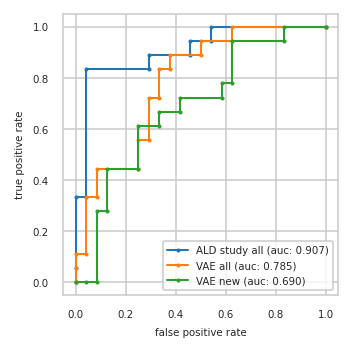

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.333   0.000 0.111   0.083 0.000
3          0.042 0.333   0.042 0.111   0.083 0.278
4          0.042 0.833   0.042 0.333   0.125 0.278
5          0.292 0.833   0.083 0.333   0.125 0.444
6          0.292 0.889   0.083 0.444   0.250 0.444
7          0.458 0.889   0.250 0.444   0.250 0.611
8          0.458 0.944   0.250 0.556   0.333 0.611
9          0.542 0.944   0.292 0.556   0.333 0.667
10         0.542 1.000   0.292 0.722   0.417 0.667
11         1.000 1.000   0.333 0.722   0.417 0.722
12           NaN   NaN   0.333 0.833   0.583 0.722
13           NaN   NaN   0.375 0.833   0.583 0.778
14           NaN   NaN   0.375 0.889   0.625 0.778
15           NaN   NaN   0.500 0.889   0.625 0.944
16           NaN   NaN   0.500 0.944   0.833 0.944
17           NaN   NaN   0.625 0.944   0.833 1.000
18           NaN   NaN   0.625 1.000   1.000 1.000
19           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P0DJI8,H0YLF3,A0A0C4DGV8;Q13214;Q13214-2
2,P01258;P01258-2;P06881,P01258;P01258-2;P06881,A0A0G2JLL6;A0A1B0GTE9;A0A1B0GTP1;Q7Z6L0;Q7Z6L0...
3,Q13231;Q13231-3,P61981,Q96GD0
4,Q9Y2T3;Q9Y2T3-3,Q9Y2T3;Q9Y2T3-3,P31321
5,P00338;P00338-3,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P04075,P14174,J3KSJ8;Q9UD71;Q9UD71-2
7,P14174,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,P61981,P25189;P25189-2,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


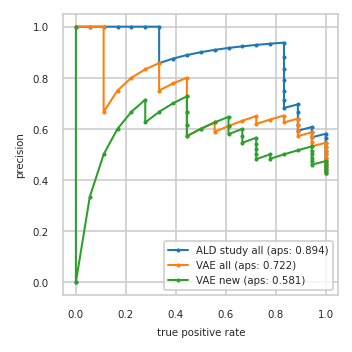

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.531 0.944     0.531 0.944
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.571 0.889     0.500 0.778
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.615 0.889     0.615 0.889     0.500 0.722
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.650 0.722     0.600 0.667
23         0.789 0.833     0.632 0.667     0.579 0.611
24         0.833 0.833     0.611 0.611     0.611 0.611
25         0.882 0.833     0.588 0.556     0.647 0.611
26         0.938 0.833     0.625 0.556     0.625 0.556
27         0.933 0.778     0.600 0.500     0.600 0.500
28         0.929 0.722     0.571 0.444     0.571 0.444
29         0.923 0.667     0.615 0.444     0.615 0.444
30         0.917 0.611     0.667 0.444     0.667 0.444
31         0.909 0.556     0.727 0.444     0.727 0.444
32         0.900 0.500     0.800 0.444     0.700 0.389
33         0.889 0.444     0.778 0.389     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         0.857 0.333     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     0.667 0.111     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


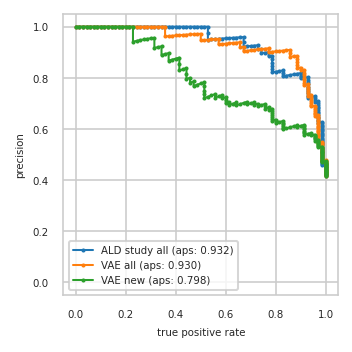

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


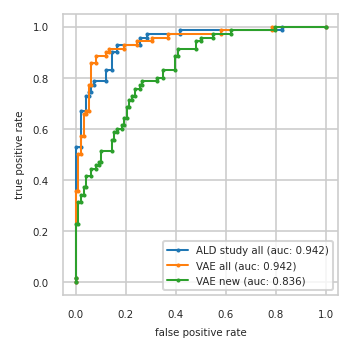

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}